##                    S3E6: Final Submission

In [19]:
# Libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from pycaret.regression import *

In [3]:
# Import train Data
df_train = pd.read_csv('train.csv')
df_train.drop('id', axis=1, inplace=True)

# Import test data
df_test = pd.read_csv('test.csv')
Id = df_test['id']
df_test = df_test.drop(columns='id')

In [4]:
# Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [5]:
# Nulls
df_train.isna().sum() # No missing values

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

### EDA

<AxesSubplot:>

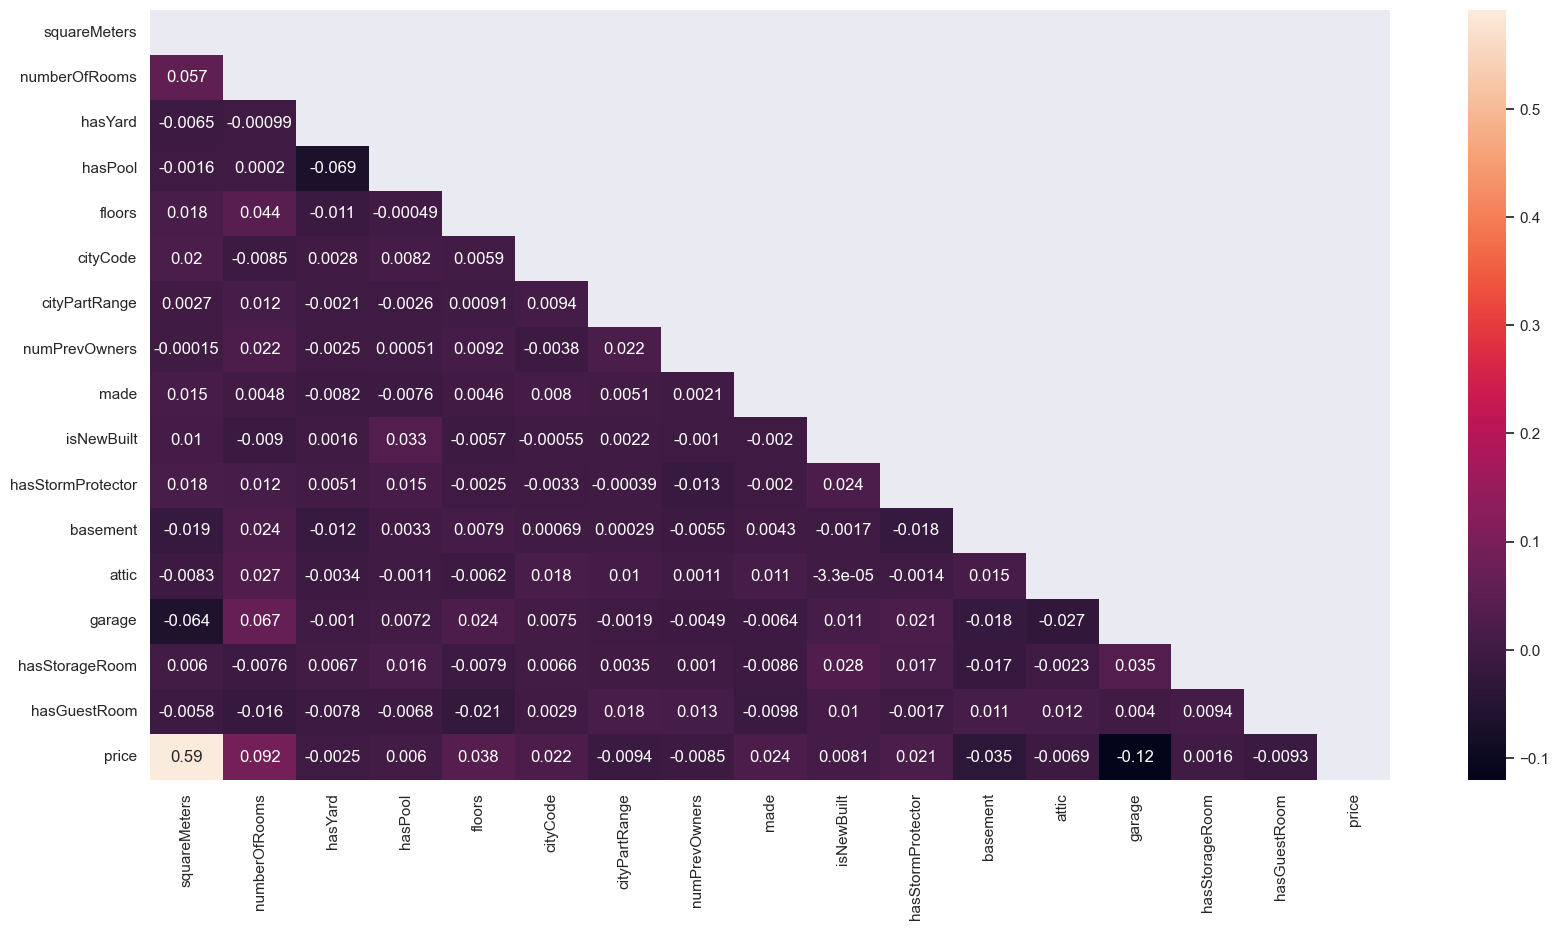

In [6]:
# Correlation Matrix
sns.set(style='darkgrid')
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(), annot=True, mask=mask)
# NOTE: squareMeters moderately correlated with price

In [7]:
# Outliers
def find_outliers_IQR(col):
   q1=col.quantile(0.25)
   q3=col.quantile(0.75)
   IQR=q3-q1
   outliers = col[((col<(q1-3*IQR)) | (col>(q3+3*IQR)))] 
   return(outliers)

for i in df_train.columns:
    outliers = find_outliers_IQR(df_train[i])
    print(i, 'Outliers: ', outliers)


squareMeters Outliers:  15334    6071330
Name: squareMeters, dtype: int64
numberOfRooms Outliers:  Series([], Name: numberOfRooms, dtype: int64)
hasYard Outliers:  Series([], Name: hasYard, dtype: int64)
hasPool Outliers:  Series([], Name: hasPool, dtype: int64)
floors Outliers:  5659    6000
Name: floors, dtype: int64
cityCode Outliers:  1326    491100
2425    465360
Name: cityCode, dtype: int64
cityPartRange Outliers:  Series([], Name: cityPartRange, dtype: int64)
numPrevOwners Outliers:  Series([], Name: numPrevOwners, dtype: int64)
made Outliers:  2113     10000
3608     10000
19124    10000
19748    10000
21400    10000
Name: made, dtype: int64
isNewBuilt Outliers:  Series([], Name: isNewBuilt, dtype: int64)
hasStormProtector Outliers:  Series([], Name: hasStormProtector, dtype: int64)
basement Outliers:  2107     84333
3995     81851
15068    91992
18926    91978
Name: basement, dtype: int64
attic Outliers:  3828     71001
4909     71001
12858    71024
13633    96381
13642    300

There are four binary variables:
- hasYard
- hasPool
- hasStormProtector
- hasStorageRoom

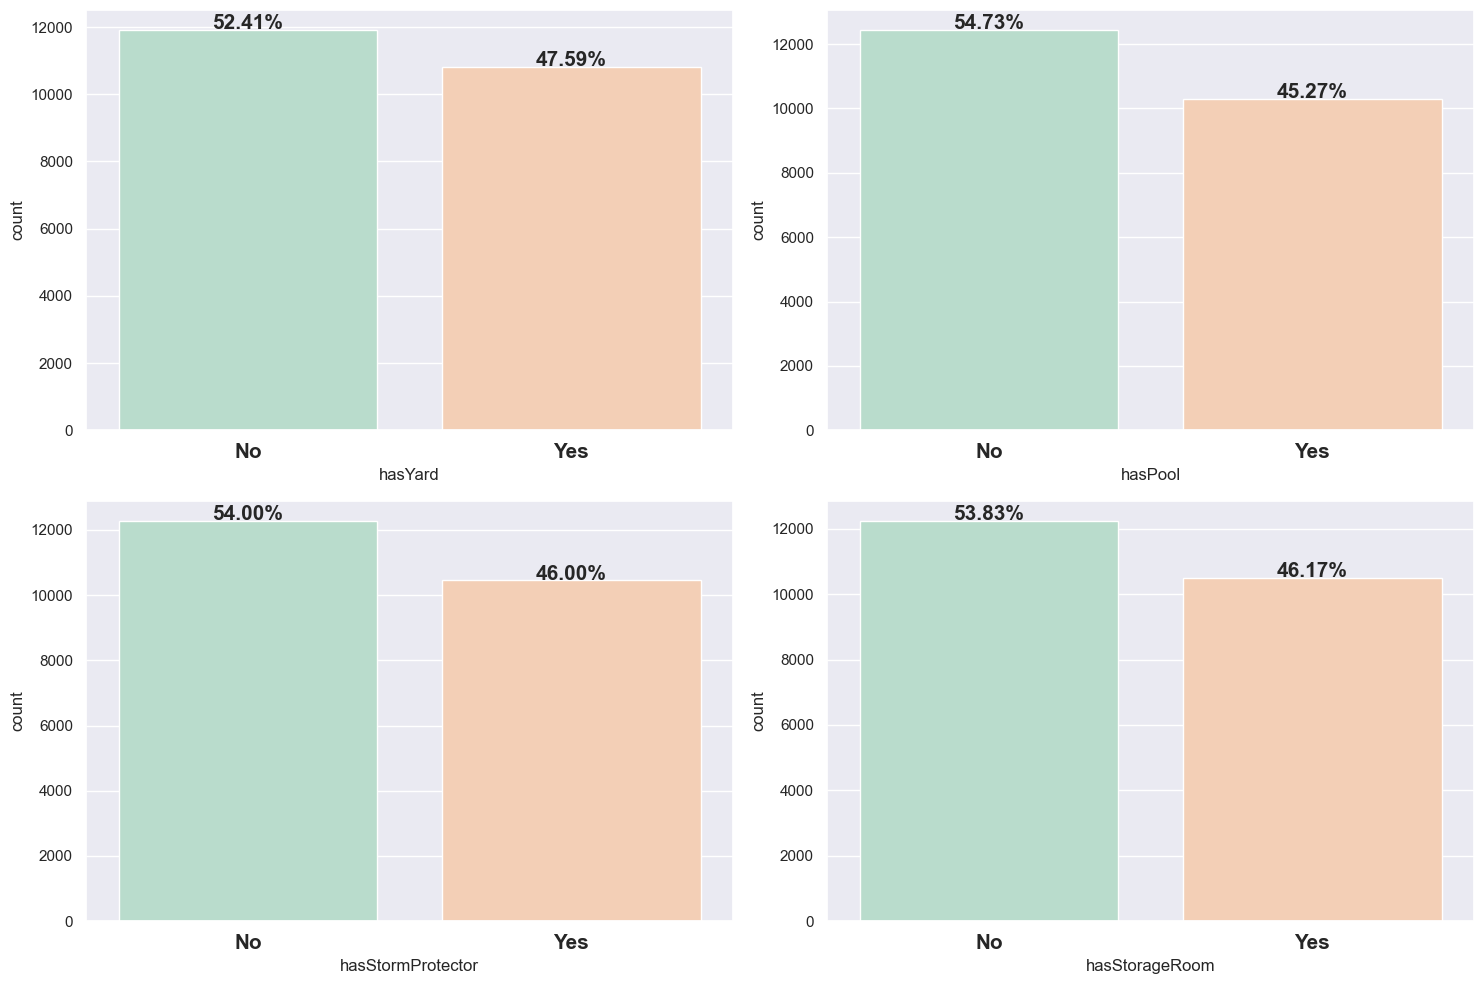

In [10]:
# Create a subplot for each binary column
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.ravel()

# Binary vars
columns = ['hasYard', 'hasPool', 'hasStormProtector', 'hasStorageRoom']
for i, column in enumerate(columns):
    sns.countplot(x=df_train[column], ax=axs[i],palette='Pastel2')
    axs[i].set_xticklabels(['No', 'Yes'], fontsize=15, fontweight='bold')
    for j in axs[i].patches:
        height = j.get_height()
        axs[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(df_train) * 100),
                ha="center", fontsize=15,fontweight='bold')

# Show the subplot
plt.tight_layout()
plt.show()

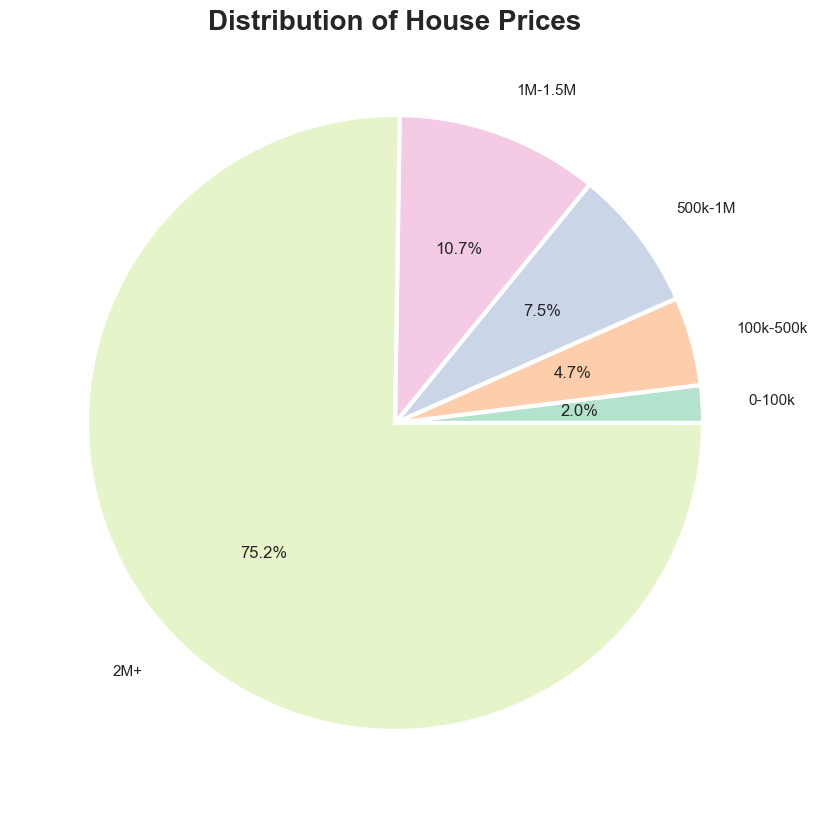

In [11]:
# TARGET: Price
plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, 2000000, df_train['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M-1.5M', '2M+']
df_train['price_range'] = pd.cut(df_train['price'], bins=bins, labels=labels)
# Pie chart
plt.pie(df_train['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
# Add a title
plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

# Show the plot
plt.show()


## MODELING

In [15]:
# Dropping outliers: Train data
df_train = df_train[df_train['squareMeters'] < 100000]
df_train = df_train[df_train['floors'] < 150]
df_train = df_train[df_train['made'] != 10000]
df_train = df_train[df_train['basement'] < 90000]
df_train = df_train[df_train['attic'] < 40000]
df_train = df_train[df_train['garage'] < 2000]

In [16]:
# pycaret setup
setup(df_train, target = 'price')
setup_df = pull()   

# Best model
best = compare_models()
compare_df = pull()
print(best)

,Description,Value
0,Session id,5951
1,Target,price
2,Target type,Regression
3,Original data shape,"(22713, 18)"
4,Transformed data shape,"(22713, 22)"
5,Transformed train set shape,"(15899, 22)"
6,Transformed test set shape,"(6814, 22)"
7,Numeric features,16
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3641.4232,4040265478.9422,45596.3445,0.9995,0.0371,0.0058,0.4150
gbr,Gradient Boosting Regressor,18935.2819,4021853132.1893,53095.9529,0.9995,0.0704,0.0187,0.2950
xgboost,Extreme Gradient Boosting,8195.8147,7186309248.0000,62306.1670,0.9992,0.0508,0.0117,0.2520
rf,Random Forest Regressor,4457.6285,11249707100.0174,79652.7194,0.9987,0.0588,0.0117,0.5900
dt,Decision Tree Regressor,4272.5464,12167308924.7726,76521.0368,0.9986,0.0542,0.0111,0.0440
lightgbm,Light Gradient Boosting Machine,23637.2235,20188613357.8491,129515.7633,0.9976,0.1120,0.0275,0.2250
llar,Lasso Least Angle Regression,28159.9801,42412559962.0258,180956.7531,0.9950,0.1340,0.0331,0.0280
lar,Least Angle Regression,28295.4702,42415103081.2188,180992.2902,0.9950,0.1311,0.0336,0.0270
omp,Orthogonal Matching Pursuit,22184.6697,42601902039.5640,180148.3627,0.9950,0.1217,0.0409,0.0260
lr,Linear Regression,28295.4702,42415103081.2187,180992.2902,0.9950,0.1311,0.0336,0.0270


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=5951)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

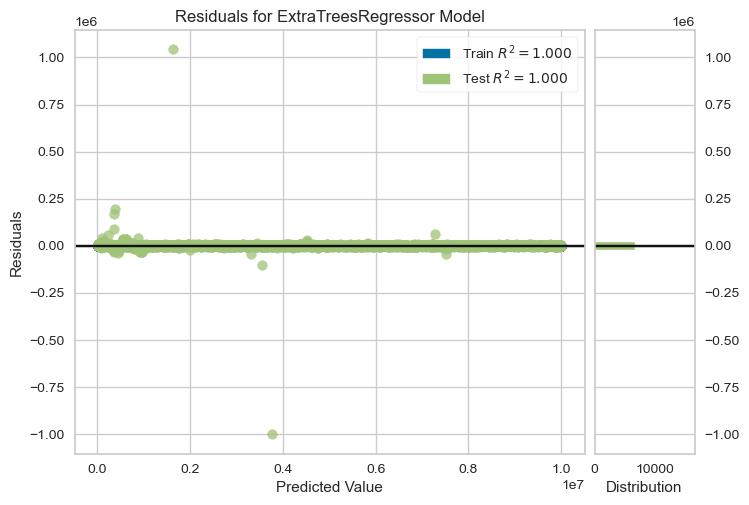

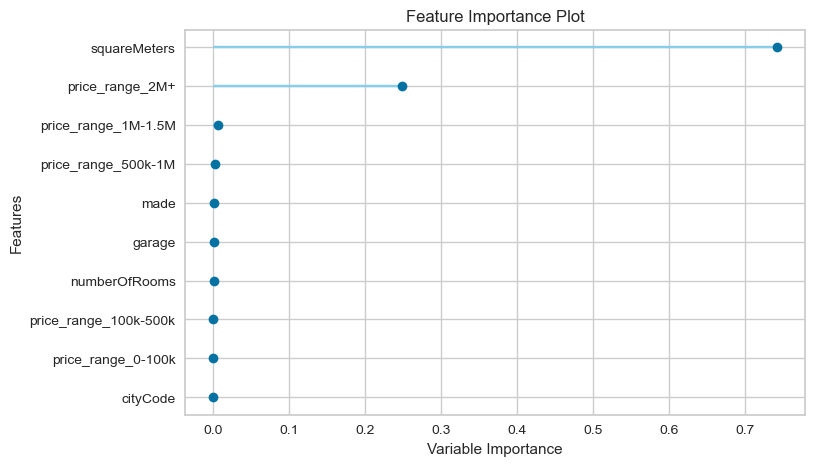

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


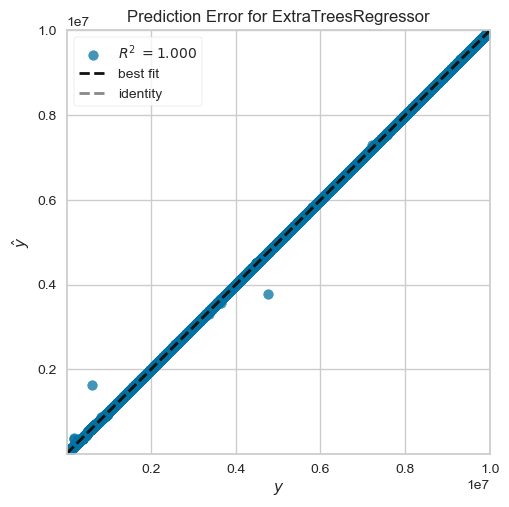

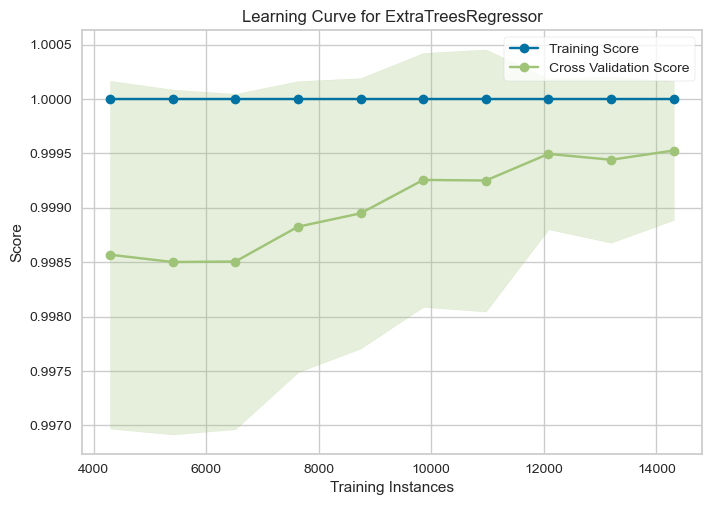

In [17]:
# Evaluate best model
evaluate_model(best)
plot_model(best, plot = 'residuals')
plot_model(best, plot='feature')
plot_model(best, plot = 'parameter')
plot_model(best, plot = 'error')
plot_model(best, plot = 'learning')

In [22]:
# Predictions using best model
test_preds = predict_model(best)
regression_results(holdout_pred['price'], holdout_pred['prediction_label']) # 75406.5986

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2708.3400,337624896.3924,18374.5720,1.0000,0.0281,0.0047


NameError: name 'holdout_pred' is not defined

In [ ]:
# Submission 11: XGBoost No outliers
sub_preds_xgb = predict_model(best, data=df_test)
sub_df_2 =  pd.DataFrame([Id, sub_preds_xgb['prediction_label']]).transpose()

sub_df_2['id'], sub_df_2['prediction_label'] = sub_df_2['id'].astype(int), sub_df_2['prediction_label'].astype(int)
sub_df_2.columns = ['id', 'price']
sub_df_2.to_csv('submission11.csv', index=False)